# Dimensionality Reduction

In [1]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy
from scipy import special
import time
import gif

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

MovieWriter Pillow unavailable; using Pillow instead.


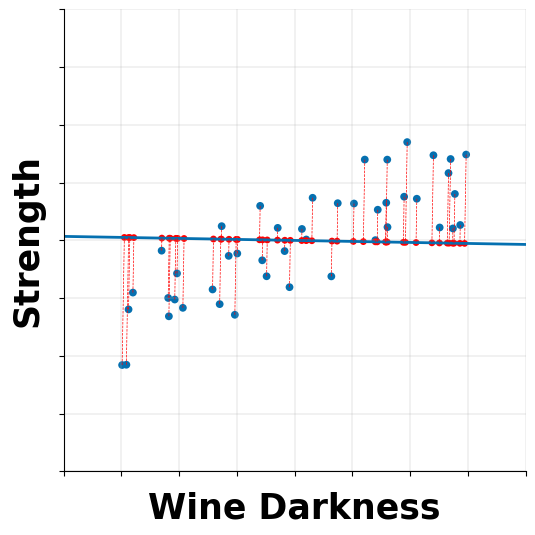

In [113]:
np.random.seed(12)

X = -0.75 + np.random.rand(45)*1.5
Y = 0.42*X + (-0.5 + np.random.rand(45))*0.5

fig, ax = plt.subplots()
ax.scatter(X,Y)
ax.set(
    xlim = [-1,1],
    ylim = [-1,1],
    xticklabels = [],
    yticklabels = [],
    xlabel = 'Wine Darkness',
    ylabel = 'Strength');
ax.yaxis.label.set_size(25)
ax.xaxis.label.set_size(25)
ax.set_box_aspect(1)


x = 2


theta  = np.pi*10/360.
alpha = np.tan(theta)
x_line = np.linspace(-1,1)


line_plot, = ax.plot(x_line,alpha*x_line)
line_plots = []
scatter_plots = []
for xx,yy in zip(X,Y):
        v = np.array([1, alpha])
        projection = np.array([xx,yy])@v.T/(v.T@v)*v
        dummy, = ax.plot([xx,projection[0]],[yy,projection[1]], 'r',linewidth=0.5, linestyle = '--' )
        line_plots.append(dummy)
        scatter_plots.append(ax.scatter(*projection, c='r',s=24))
        





def animate(i):
    
    
    alpha = 2*np.pi*i/360.
    a = np.tan(alpha)
    line_plot.set_ydata(a*x_line)
    
    
    v = np.array([1, a])
    
    
    for jj, (xx,yy) in enumerate(zip(X,Y)):
        
        projection = np.array([xx,yy])@v.T/(v.T@v)*v
        line_plots[jj].set_ydata([yy,projection[1]])
        line_plots[jj].set_xdata([xx,projection[0]])
        scatter_plots[jj].set_offsets(projection)
        
        
        line_plots.append(dummy)
    
    return line_plots
#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     print(line_plot)
    
# Init only required for blitting to give a clean slate.
def init():
    line_plot.set_ydata(np.ma.array(x_line, mask=True))
    return line_plot,


ani = FuncAnimation(fig, animate, np.linspace(0, 179,360), init_func=init,
                              interval=25, blit=True)
ani.save('animation.gif', writer='Pillow', fps=60)

In [102]:
def AAA(alpha=70):
    np.random.seed(15)

    X = -0.5 + np.random.rand(45)
    Y = X + (-0.5 + np.random.rand(45))*0.5

    fig, ax = plt.subplots()
    ax.scatter(X,Y)
    ax.set(
        xlim = [-1,1],
        ylim = [-1,1],
#         xticklabels = [],
#         yticklabels = [],
        xlabel = 'Wine Darkness',
        ylabel = 'Strength');


    theta  = 2*np.pi*alpha/360.
    m = np.tan(theta)
    x_line = np.linspace(-1,1,1000)


#     line_plot, = ax.plot(x_line,alpha*x_line)
    line_plots = []
    scatter_plots = []
    
    def normalized(a, axis=-1, order=2):
        l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
        l2[l2==0] = 1
        return (a / np.expand_dims(l2, axis))[0]
    
    v = np.array([1, m])
    v = normalized(v)
    
    ax.scatter([0],[0],color='k')
    
    
    def circle(x, minus=1):
        return minus * np.sqrt(1 - x**2)
    
    xxx = np.linspace(-1,1,1000)
    ax.plot(xxx,circle(xxx),'k')
    ax.plot(xxx,circle(xxx,-1),'k')

    ax.set_box_aspect(1)
    for xx,yy in zip(X,Y):         
            
            projection = np.dot(np.array([xx,yy]),v)/np.dot(v,v)*v
            dummy, = ax.plot([xx,projection[0]],[yy,projection[1]], 'r',linewidth=0.5, linestyle = '--' )
            line_plots.append(dummy)
            scatter_plots.append(ax.scatter([projection[1]],[projection[0]], c='r',s=24))

        



widgets.interactive(AAA,alpha=(0,179,10))


interactive(children=(IntSlider(value=70, description='alpha', max=179, step=10), Output()), _dom_classes=('wi…

\begin{equation}
U = m \cdot K + b
\end{equation}

Die Äquivalenz können wir nun sehen, wenn wir uns die Gleichung des Neurons genauer anschauen:

\begin{equation}
z = K \cdot w_1 + U \cdot w_2
\end{equation}

Nun wissen wir, dass das Neuron einen Punkt der Klasse $A$ zuordnet, wenn $z<s$ gilt, und der Klasse $B$, wenn $z>s$ gilt. 
Das bedeutet, dass wir bei $z=s$ eine Grenze zwischen den beiden Klassen ziehen können.
Wenn wir $z=s$ einsetzen und nach $U$ umformen, bekommen wir:

\begin{equation}
z = K \cdot w_1 + U \cdot w_2 = s \qquad \Leftrightarrow \qquad U \cdot w_2 = - K \cdot w_1 + s \qquad \Leftrightarrow \qquad U = \left(-\frac{w_1}{w_2}\right) \cdot K + \frac{s}{w_2}
\end{equation}

Hier sehen wir die selbe Geradengleichung wie zu Beginn, wenn wir $m=\left(-\frac{w_1}{w_2}\right)$ und $b=\frac{s}{w_2}$ setzen.
    


In [1]:
def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Corresponding matrix of eigenvectors
    (numpy array of floats)    : Vector of eigenvalues

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals

def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix

def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors

def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y